<a href="https://colab.research.google.com/github/vithushanms/makemore-language-model/blob/main/%5BLanguage_Models%5D_makemore_Further_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
#if cloud
from google.colab import drive
drive.mount('/content/drive')
dataFilePath = '/content/drive/My Drive/Publications and Researches/Neural Networks Research/makemore: next char prediction language model/names.txt'
words = open(dataFilePath, 'r').read().splitlines()

Mounted at /content/drive


In [3]:
# encode chars in the words to integer
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
C = torch.randn((27,10),requires_grad=True)
W1 = torch.randn((30,300),  requires_grad=True)
b1 = torch.randn(300, requires_grad=True)
W2 = torch.randn((300, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [6]:
stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  (32 * 3 * 10)
  logits = ((emb.view(-1,dimension) @ W1 + b1).tanh()) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())

In [7]:
@torch.no_grad()
def split_loss(split):
  X, Y = {
      'test' : { Xtest, Ytest },
      'dev' : { Xdev, Ydev },
      'train': { Xtr, Ytr }
  }[split]
  emb = C[X]
  out_h = (emb.view(-1, dimension) @ W1 + b1).tanh()
  logits = out_h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} : {loss.item()}')

In [8]:
split_loss('dev')
split_loss('train')

dev : 2.4837751388549805
train : 2.4312379360198975


If we print all the loss in the iteration the loss starts at very high number

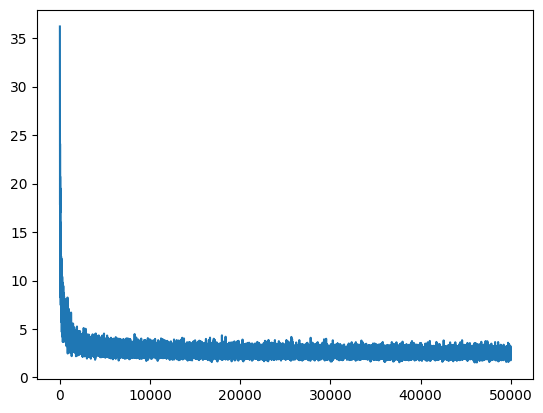

In [9]:
plt.plot(stepi, lossi)

This makes the model iterate few times unnessesarily and makes the training process more innefficent. therefore we can start from a realistic loss

since we have the 27 characters the releastic probability for the model would be somewhere close to 1/27

In [10]:
#releastic loss would be close to
-torch.tensor((1/27)).log()

tensor(3.2958)

In [11]:
#modifyin the last layer's output logits to be very close to 0, then it would probabily
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
# 228416 * 3 * 10
# 228416 * 1 * 30

W1 = torch.randn((n_emb*3,n_hidden))
# 30 * 200
# 1 * 200
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) * 0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [12]:
stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)
  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())

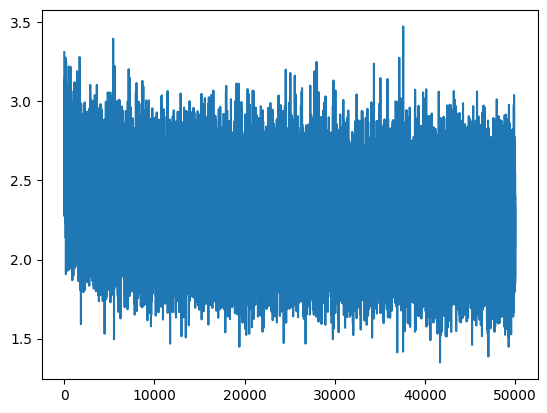

In [13]:
plt.plot(stepi, lossi)

Now if we look at the output from the hidden layers are basically passing through the tanh function. let's see the values which are coming out from this tanh activation in a histogram

(array([2672.,  212.,  130.,   79.,   97.,   74.,   95.,  148.,  188.,
        2705.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

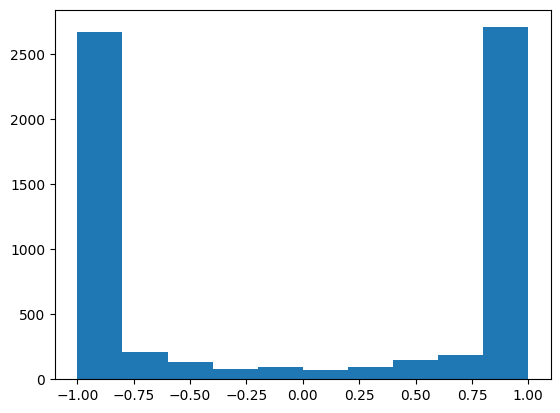

In [14]:
plt.hist(out_h.view(-1).tolist())

Since most of them are close to 1 and -1, it's not a very good sign

(array([   9.,   72.,  292.,  862., 1607., 1784., 1201.,  443.,  115.,
          15.]),
 array([-21.43138504, -17.29958611, -13.16778717,  -9.03598824,
         -4.9041893 ,  -0.77239037,   3.35940857,   7.4912075 ,
         11.62300644,  15.75480537,  19.88660431]),
 <BarContainer object of 10 artists>)

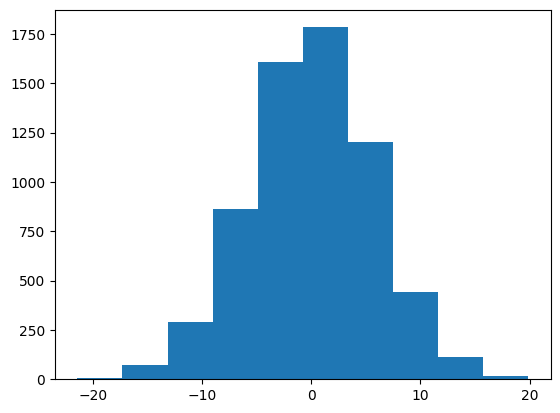

In [15]:
plt.hist(out_h_preactivation.view(-1).tolist())

The derevative of the tanh is going to be 1 - tanh**2. So, the values which are in the tails which is 1 or -1 from the outcome will be staying in very close to 0 when we backpropogate the tanh function. therefore it never gonna get activated

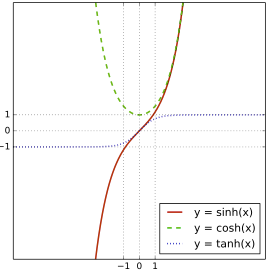

Let's analyze this with respect to our training mini batch during the last iteration

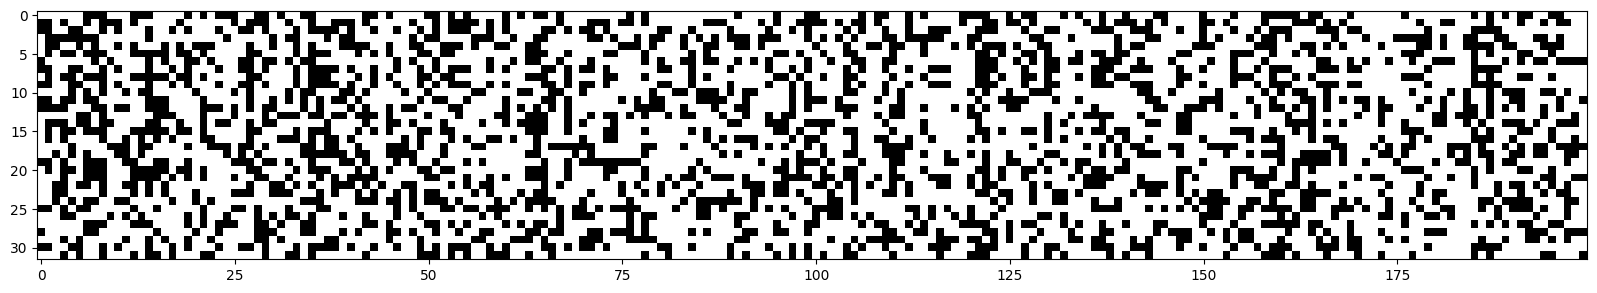

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(out_h.abs() > 0.99, cmap='gray', interpolation='nearest')

#here x axis is going to be the neuron in the hidden layer
#y axis is going to be the concatinated emb values going through the neurons
#the white color boxes are going to be the ones which doesn't activate the neurons, in the other words absolute value of out_h is higher than 0.99 and falling in the flat side of tanh

There we can't see the flat all complete white boxes in any columns. which is kind of a good news

This conncept will be applicable for other activation non linear activations such as sigmoid, tanh, relu, etc. when the value get fall into flat region of the activation function it's never gonna activbate the neurons


This issue can be fixed by tunning the initial weights and the bias of the layer to be close to zero or very small. because the out_h is coming from the contact emb after going through the weights and bias

In [17]:
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
W1 = torch.randn((n_emb*3,n_hidden)) *  ((5/3) / 30**0.5)
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) *0
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)
  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())



(array([1442.,  414.,  326.,  409.,  518.,  502.,  380.,  355.,  471.,
        1583.]),
 array([-1.00000000e+00, -8.00000054e-01, -6.00000107e-01, -4.00000161e-01,
        -2.00000215e-01, -2.68220901e-07,  1.99999678e-01,  3.99999624e-01,
         5.99999571e-01,  7.99999517e-01,  9.99999464e-01]),
 <BarContainer object of 10 artists>)

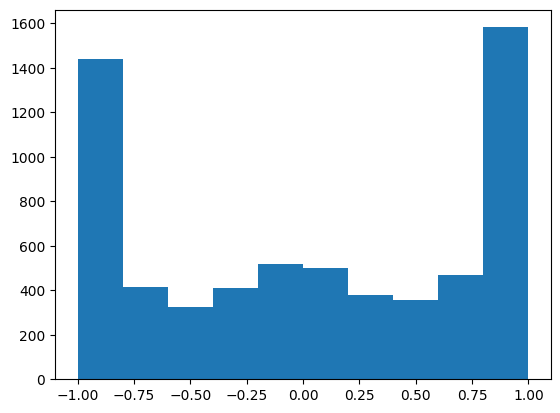

In [18]:
plt.hist(out_h.view(-1).tolist())

(array([1.000e+00, 6.000e+00, 3.700e+01, 2.530e+02, 9.160e+02, 2.805e+03,
        1.690e+03, 5.520e+02, 1.270e+02, 1.300e+01]),
 array([-10.25064754,  -8.46831479,  -6.68598204,  -4.90364928,
         -3.12131653,  -1.33898377,   0.44334898,   2.22568173,
          4.00801449,   5.79034724,   7.57268   ]),
 <BarContainer object of 10 artists>)

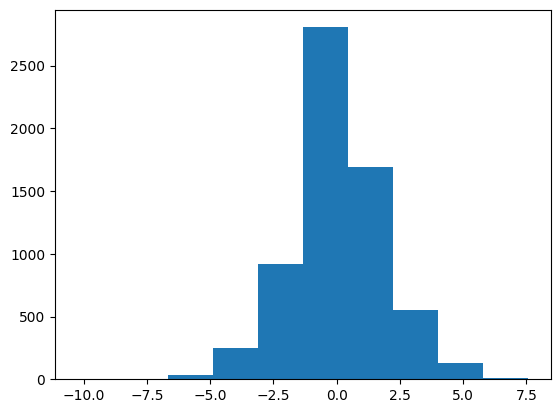

In [19]:
plt.hist(out_h_preactivation.view(-1).tolist())

In [20]:
out_h_preactivation.std()

tensor(1.8180, grad_fn=<StdBackward0>)

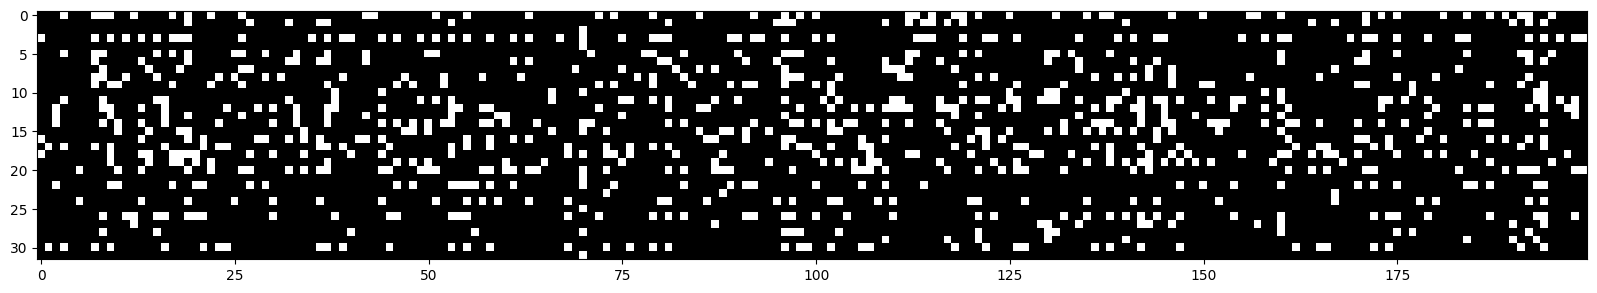

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(out_h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [22]:
#when we calculate the loss, now we can see the improvements
split_loss('dev')
split_loss('train')

dev : 2.2062768936157227
train : 2.163710594177246


But the multipliers to scale initial down parameters are not to be hardcoded. therefore we need to identify an automated way to do this

x: mean - 0.0040525514632463455 sdx - 1.0015943050384521
y: mean - 0.02456771396100521 sdy - 9.727545738220215


(array([2.19308483e-06, 0.00000000e+00, 4.38616966e-06, 6.57925449e-06,
        1.97377635e-05, 2.41239331e-05, 7.01787145e-05, 1.05268072e-04,
        1.35971259e-04, 2.19308483e-04, 4.01334524e-04, 6.82049382e-04,
        1.12285943e-03, 1.70402691e-03, 2.85758953e-03, 4.44099678e-03,
        6.71961192e-03, 1.00070461e-02, 1.43800572e-02, 2.01522565e-02,
        2.65165887e-02, 3.31002293e-02, 3.82890680e-02, 4.24252260e-02,
        4.36314227e-02, 4.20852979e-02, 3.72034910e-02, 3.12975136e-02,
        2.39616448e-02, 1.82903275e-02, 1.34830855e-02, 8.82935952e-03,
        6.10554816e-03, 3.98483513e-03, 2.50011671e-03, 1.53296630e-03,
        9.89081258e-04, 5.89939819e-04, 2.96066452e-04, 1.77639871e-04,
        1.00881902e-04, 8.77233932e-05, 3.28962724e-05, 2.41239331e-05,
        1.09654241e-05, 4.38616966e-06, 4.38616966e-06, 4.38616966e-06,
        0.00000000e+00, 2.19308483e-06]),
 array([-55.51175308, -53.23185951, -50.95196594, -48.67207237,
        -46.3921788 , -44.1122

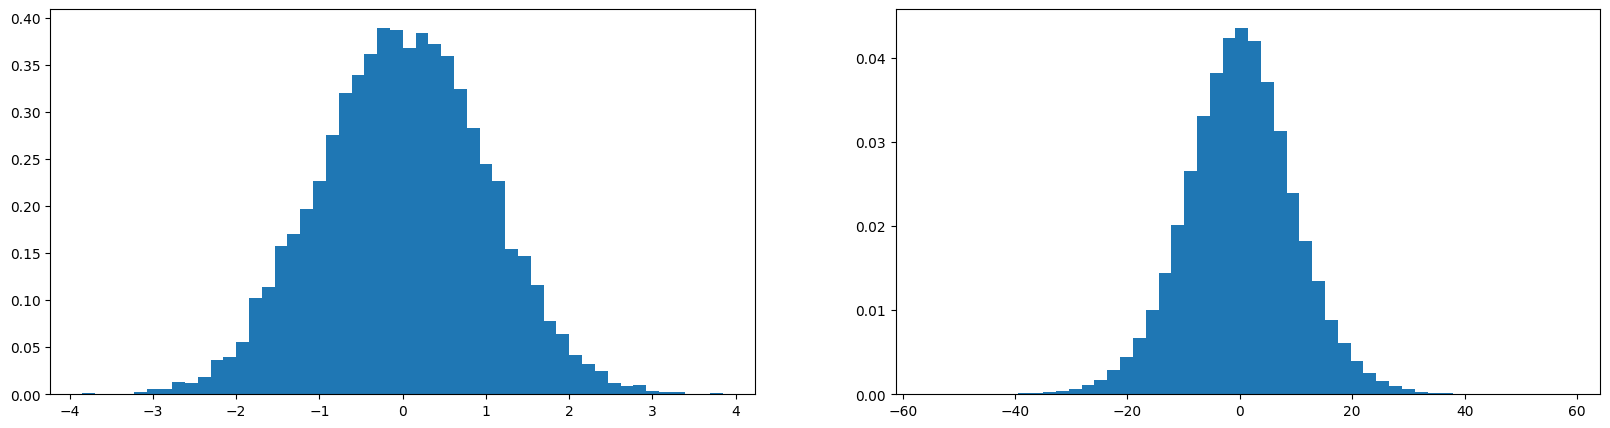

In [23]:
x = torch.randn(1000,10)
w = torch.randn(10,200) * 10**0.5
y = x @ w
print(f'x: mean - {x.mean()} sdx - {x.std()}')
print(f'y: mean - {y.mean()} sdy - {y.std()}')

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)

A Gaussian distribution, also known as a normal distribution, is a probability distribution that is commonly used to model natural phenomena and data in many fields of science and engineering. The distribution is characterized by its bell-shaped curve that is symmetric around the mean.

The Gaussian distribution has two parameters: the mean (μ) and the standard deviation (σ). The mean is the average value of the distribution and represents the center of the curve. The standard deviation is a measure of the spread or dispersion of the data around the mean.

In a Gaussian distribution, approximately 68% of the data falls within one standard deviation of the mean, approximately 95% of the data falls within two standard deviations of the mean, and approximately 99.7% of the data falls within three standard deviations of the mean. This is known as the 68-95-99.7 rule or the empirical rule.

Many natural phenomena and measurements follow a Gaussian distribution, including the heights of people, weights of objects, errors in measurements, and many other physical and biological measurements. Therefore, the Gaussian distribution is widely used in statistical modeling, data analysis, and many other applications.

WHY WE NEED TO USE GUSSIAN DISTRIBUTION: https://arxiv.org/pdf/1502.01852.pdf

x: mean - 0.008257376030087471 sdx - 1.0071933269500732
y: mean - 0.0026993402279913425 sdy - 1.4359740018844604


(array([6.43793525e-05, 6.43793525e-05, 6.43793525e-05, 1.77043219e-04,
        2.89707086e-04, 5.63319334e-04, 9.17405773e-04, 1.25539737e-03,
        2.57517410e-03, 4.60312370e-03, 6.92078039e-03, 1.14112402e-02,
        1.68191058e-02, 2.56873616e-02, 3.86598012e-02, 5.32578194e-02,
        7.88486120e-02, 1.10297926e-01, 1.42777309e-01, 1.85525199e-01,
        2.22237525e-01, 2.58917661e-01, 2.87550378e-01, 2.96418634e-01,
        2.92024743e-01, 2.64084104e-01, 2.24410328e-01, 1.88824641e-01,
        1.46817113e-01, 1.08060743e-01, 8.03776216e-02, 5.67503992e-02,
        3.94645431e-02, 2.56068875e-02, 1.73019510e-02, 1.11376280e-02,
        6.87249588e-03, 4.42608048e-03, 2.80050183e-03, 1.83481155e-03,
        1.01397480e-03, 6.11603849e-04, 1.93138058e-04, 2.41422572e-04,
        1.12663867e-04, 3.21896763e-05, 3.21896763e-05, 0.00000000e+00,
        0.00000000e+00, 3.21896763e-05]),
 array([-7.30713367, -6.99647507, -6.68581646, -6.37515785, -6.06449924,
        -5.75384064, 

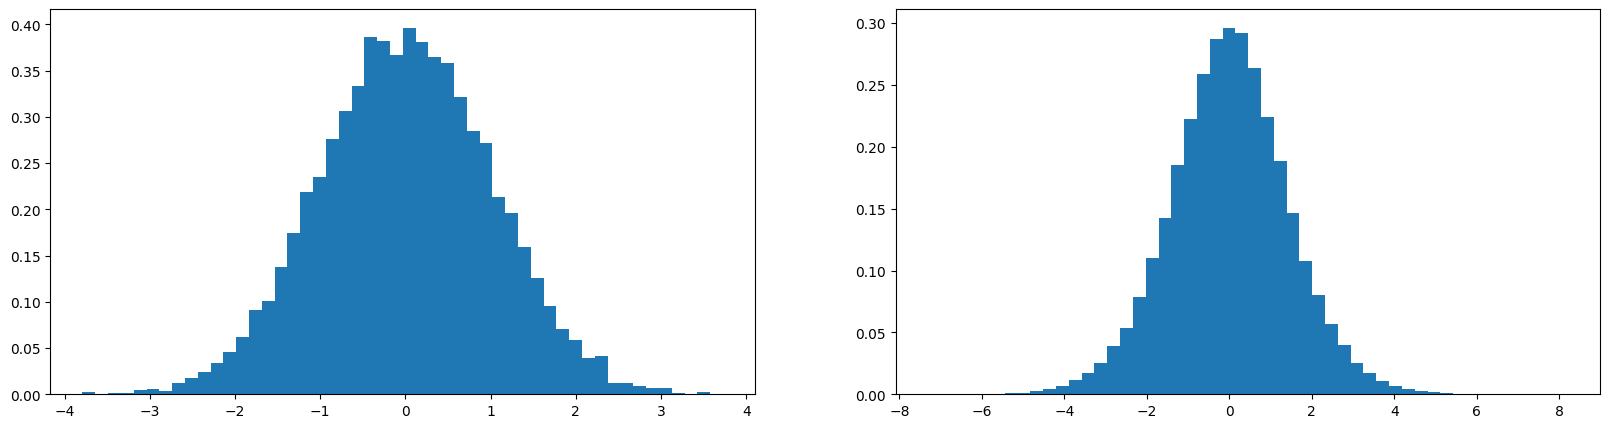

In [24]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10 ** 0.5
w = torch.randn(10,200) * (1/10 ** 0.5)
w = torch.randn(10,200) / (1/2 * 10) ** 0.5
# w = torch.randn(10,200) * (2/10) ** 0.5
y = x @ w
print(f'x: mean - {x.mean()} sdx - {x.std()}')
print(f'y: mean - {y.mean()} sdy - {y.std()}')

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)

we can use torch.nn.init.kaiming_normal_()

In [25]:
#so the number is for tanh is going to be
(5/3) / 30**0.5

0.3042903097250923

In [26]:
x = [2, 3, 5, 2]
x = torch.tensor(x, dtype=float)
print(x.mean())

tensor(3., dtype=torch.float64)


This is not really very important these days as the optimization we use later on

Batch normalization: https://arxiv.org/pdf/1502.03167.pdf

This paper eloborate the fact that tuning the preactivation to be gussian and taking the preactivation and making it gusssian are two different operations


In [27]:
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
W1 = torch.randn((n_emb*3,n_hidden)) * ((5/3) / 30)**0.5
# b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) *0

#scalling shift
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)

  #normalize pre activation to be gussuan distribution
  out_h_preactivation = (bngain * (out_h_preactivation - out_h_preactivation.mean(0, keepdim=True)) / out_h_preactivation.std(0, keepdim=True)) + bnbias

  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())



In [28]:
@torch.no_grad()
def split_loss(split):
  X, Y = {
      'test' : { Xtest, Ytest },
      'dev' : { Xdev, Ydev },
      'train': { Xtr, Ytr }
  }[split]
  emb = C[X]
  out_h_preactivation = (emb.view(-1, dimension) @ W1 + b1)
  out_h_preactivation = (bngain * (out_h_preactivation - out_h_preactivation.mean(0, keepdim=True)) / out_h_preactivation.std(0, keepdim=True)) + bnbias
  out_h = out_h_preactivation.tanh()
  logits = out_h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} : {loss.item()}')

In [29]:
split_loss('train')
split_loss('dev')

train : 2.174910545349121
dev : 2.197132110595703


In [30]:
#we can have a unified training gain and the bias for batch
with torch.no_grad():
  emb = C[Xtr]
  h_preactivate = emb.view(emb.shape[0], dimension) @ W1 + b1
  bnmean = h_preactivate.mean(0, keepdim=True)
  bnstd = h_preactivate.std(0, keepdim=True)

In [31]:
@torch.no_grad()
def split_loss(split):
  X, Y = {
      'test' : { Xtest, Ytest },
      'dev' : { Xdev, Ydev },
      'train': { Xtr, Ytr }
  }[split]
  emb = C[X]
  out_h_preactivation = (emb.view(-1, dimension) @ W1 + b1)
  out_h_preactivation = (bngain * (out_h_preactivation - bnmean) / bnstd) + bnbias
  out_h = out_h_preactivation.tanh()
  logits = out_h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} : {loss.item()}')

split_loss('train')
split_loss('dev')

train : 2.174910545349121
dev : 2.196995973587036


In [32]:
#we can do the same as running mean and running std in the process of converging
n_emb = 10
n_hidden = 200
C = torch.randn((27,n_emb))
W1 = torch.randn((n_emb*3,n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, 27)) * 0.01
b2 = torch.randn(27) *0

#initialise it to be a gussian
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

#scalling shift
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

stepi = []
lrei = []
lossi = []

minibatch_size = 32
dimension = 30
num_0f_iteration = 50000

for i in range(num_0f_iteration):
  #pick up random mini batches of 32 row from the data set in the each iteration
  rand_index = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  #forward pass
  emb = C[Xtr[rand_index]]
  out_h_preactivation = (emb.view(-1,dimension) @ W1 + b1)
  bnmeani = out_h_preactivation.mean(0, keepdim=True)
  bnstdi = out_h_preactivation.std(0, keepdim=True)

  #normalize pre activation to be gussuan distribution
  out_h_preactivation = (bngain * (out_h_preactivation - bnmeani) / bnstdi) + bnbias

  with torch.no_grad():
    #here 0.001 momentum
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  out_h = out_h_preactivation.tanh()
  logits = (out_h) @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[rand_index])

  #backward
  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  #tune the parameters
  for p in parameters:
    p.data += -0.1 * p.grad

  stepi.append(i)
  #lrei.append(lr)
  lossi.append(loss.item())



In [33]:
#we can have a unified training gain and the bias for batch
with torch.no_grad():
  emb = C[Xtr]
  h_preactivate = emb.view(emb.shape[0], dimension) @ W1 + b1
  bnmean = h_preactivate.mean(0, keepdim=True)
  bnstd = h_preactivate.std(0, keepdim=True)
bnmean

tensor([[-3.5365e+00, -2.4038e+00,  1.2592e+00, -9.7460e-01,  1.4767e+00,
          4.5950e+00,  6.6945e+00, -3.4511e+00,  6.6168e+00, -1.6007e+00,
          6.6785e-01, -3.3954e+00, -3.1372e+00, -5.2530e-01, -1.1183e+00,
         -3.5343e-01,  9.6904e-01, -3.2350e+00,  6.3800e-01,  1.1613e+00,
          1.6115e+00,  1.5225e+00,  3.7654e+00, -1.3192e+00, -3.4794e+00,
          3.4749e+00, -1.1883e-01, -1.9604e-01, -4.4608e+00, -5.2474e+00,
         -6.2881e-01, -5.2616e+00,  6.1847e+00,  2.7745e+00, -1.8057e+00,
         -3.9225e-01,  6.6578e-02, -1.6188e+00,  7.0959e-01,  3.9912e+00,
         -4.8282e-01,  6.5852e-01, -3.7359e+00, -2.2927e+00,  4.5215e+00,
          4.4209e+00, -1.5240e+00, -1.2507e+00, -6.3075e-01, -3.4378e+00,
         -9.4308e-01, -1.2836e+00,  6.6543e+00,  9.1094e-01, -6.6619e+00,
         -6.3912e+00, -2.7510e+00,  4.2903e+00,  7.5021e-01,  6.1059e+00,
          5.6948e-01,  3.3260e+00, -1.9635e+00,  1.7072e+00, -5.3679e-01,
         -2.3072e+00,  5.5237e-01, -8.

In [34]:
bnmean_running

tensor([[-3.5411, -2.3980,  1.2193, -1.0024,  1.4279,  4.5059,  6.6365, -3.4111,
          6.6405, -1.5782,  0.7221, -3.4212, -3.1535, -0.4903, -1.0976, -0.4202,
          1.0467, -3.2078,  0.6359,  1.2439,  1.5373,  1.4213,  3.6846, -1.3151,
         -3.4400,  3.4927, -0.1115, -0.1809, -4.4339, -5.2721, -0.7331, -5.2897,
          6.1567,  2.7664, -1.7848, -0.3461,  0.0540, -1.5205,  0.6949,  3.9897,
         -0.4315,  0.6823, -3.6742, -2.2728,  4.4636,  4.4368, -1.5593, -1.2316,
         -0.6316, -3.4635, -0.9573, -1.2118,  6.6392,  0.9050, -6.6091, -6.3327,
         -2.7273,  4.2931,  0.7125,  5.9676,  0.5900,  3.3397, -1.9297,  1.7630,
         -0.4622, -2.3257,  0.5609, -0.8148,  1.4980, -3.0586,  2.1874,  3.8295,
          3.2819,  2.6794,  1.3961,  2.5460,  1.1923, -0.9337, -1.1647, -0.9858,
          1.1409,  0.6042, -2.9531, -1.0372,  4.5472,  3.7444,  3.5903,  0.7494,
         -4.5716, -1.0176,  1.5730,  0.7205,  0.0498, -5.7974, -3.1770,  0.7977,
          0.3249, -0.0149,  

In [35]:
@torch.no_grad()
def split_loss(split):
  X, Y = {
      'test' : { Xtest, Ytest },
      'dev' : { Xdev, Ydev },
      'train': { Xtr, Ytr }
  }[split]
  emb = C[X]
  out_h_preactivation = (emb.view(-1, dimension) @ W1 + b1)
  out_h_preactivation = (bngain * (out_h_preactivation - bnmean_running) / bnstd_running) + bnbias
  out_h = out_h_preactivation.tanh()
  logits = out_h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} : {loss.item()}')

split_loss('train')
split_loss('dev')

train : 2.208242893218994
dev : 2.2259278297424316


In this neural net the data is already sort of gussian. so the effect impact here is not that much. But in the real life, it would be a challenge with non gussian data. so in those scenarios the batch normalizations would help

Batch normalization has a regularizing effect on neural networks, meaning it can help to prevent overfitting and improve the generalization performance of the model.

The regularization effect of batch normalization arises from the fact that it introduces noise into the network during training. Specifically, the normalization process adds a small amount of random noise to the inputs to each layer, which can help to prevent the network from overfitting to the training data.

In addition to the noise introduced by the normalization process, batch normalization also helps to reduce the internal covariate shift, which can make the training of the network more stable and improve the generalization performance of the model.

Moreover, batch normalization also has an explicit regularization effect through the use of two additional learnable parameters, the scaling and shifting parameters. These parameters allow the network to learn the appropriate scale and shift for the normalized inputs, which can help to prevent the network from becoming too sensitive to small changes in the inputs.

Overall, the regularization effect of batch normalization is one of the key reasons why it has become a popular technique for improving the training and generalization performance of neural networks.

Batch normalization has not been deprecated, and is still a commonly used technique in modern deep learning architectures. In fact, batch normalization is considered to be one of the most effective techniques for improving the training and generalization performance of deep neural networks.

However, there have been some criticisms of batch normalization in certain contexts, particularly when used with small batch sizes or in combination with other regularization techniques. Some researchers have argued that batch normalization can lead to over-regularization in these cases, which can hurt the performance of the model.

Additionally, there have been some proposed alternatives to batch normalization that aim to improve on its performance or address some of its limitations. For example, layer normalization and group normalization are two related techniques that can be used as alternatives to batch normalization in certain contexts.

Despite these criticisms and alternative techniques, batch normalization remains a widely used and effective technique for improving the training and generalization performance of deep neural networks. It is still a fundamental component of many modern deep learning architectures and is likely to remain so for the foreseeable future.

In [36]:
split_loss('train')
split_loss('dev')

train : 2.208242893218994
dev : 2.2259278297424316


In [37]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      out_h_preactivation = emb.view(1, -1) @ W1 + b1
      out_h_preactivation = (bngain * (out_h_preactivation - bnmean_running) / bnstd_running) + bnbias
      h = out_h_preactivation.tanh()
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

junnde.
tayanna.
paylah.
adie.
kairrito.
coss.
tem.
kalania.
zamilenyas.
dedainr.
imordseon.
evy.
arten.
aveum.
kafontum.
maryas.
waleyann.
core.
yarion.
kaevandi.


Refactoring the code to the pytorch stucture to look like how the pytorch modules will look work internally

In [137]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(itos)

C = torch.randn((vocab_size, n_embd),            generator=g)

# ----------------- with batch norm layer -------------------------------------------------
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]

# ----------------- before batch norm ---------------------------------------------------------
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

# ---------------- Linear Layer ---------------------------------------------------------------
# layers = [
#   Linear(n_embd * block_size, n_hidden),
#   Linear(           n_hidden, n_hidden),
#   Linear(           n_hidden, n_hidden),
#   Linear(           n_hidden, n_hidden),
#   Linear(           n_hidden, n_hidden),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [138]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
     break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2988


layer 0 (    Linear): mean -0.06, std 1.06, saturated: 35.25%
layer 2 (    Linear): mean -0.01, std 0.75, saturated: 19.22%
layer 4 (    Linear): mean +0.02, std 0.71, saturated: 16.94%
layer 6 (    Linear): mean -0.03, std 0.71, saturated: 18.12%
layer 8 (    Linear): mean +0.01, std 0.72, saturated: 18.31%


Text(0.5, 1.0, 'activation distribution')

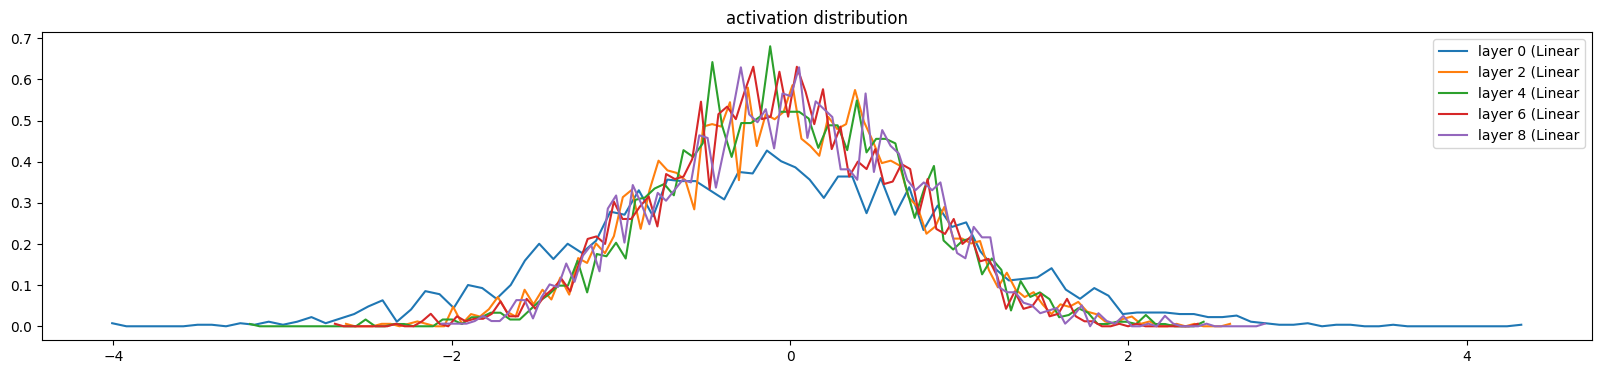

In [139]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# Before batch norm

## Observations on the activations

- here initialization happens as the xavier initialization, so there is no gain, so if we take out the gain 5/3, we are seeing that the first layer is fine but further layers the saturation on the tails are becoming 0, which means values after activations are squashed and becomming mostly zero
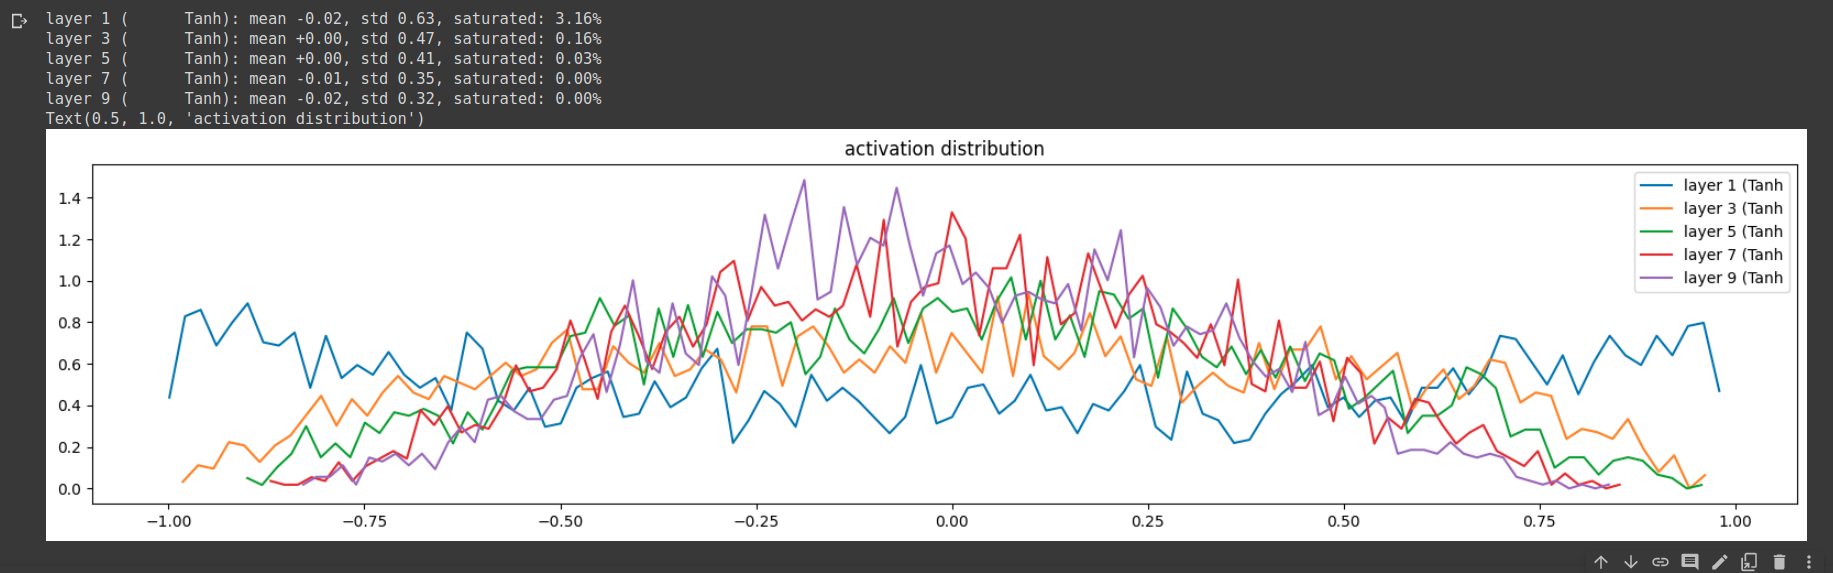

- when we have the gain 5/3 all the layers are perfectly saturating and in until the last layer at acceptable ammount. this means the 5/3 gain helps to fight back the squashing as per the kaiming he initialization
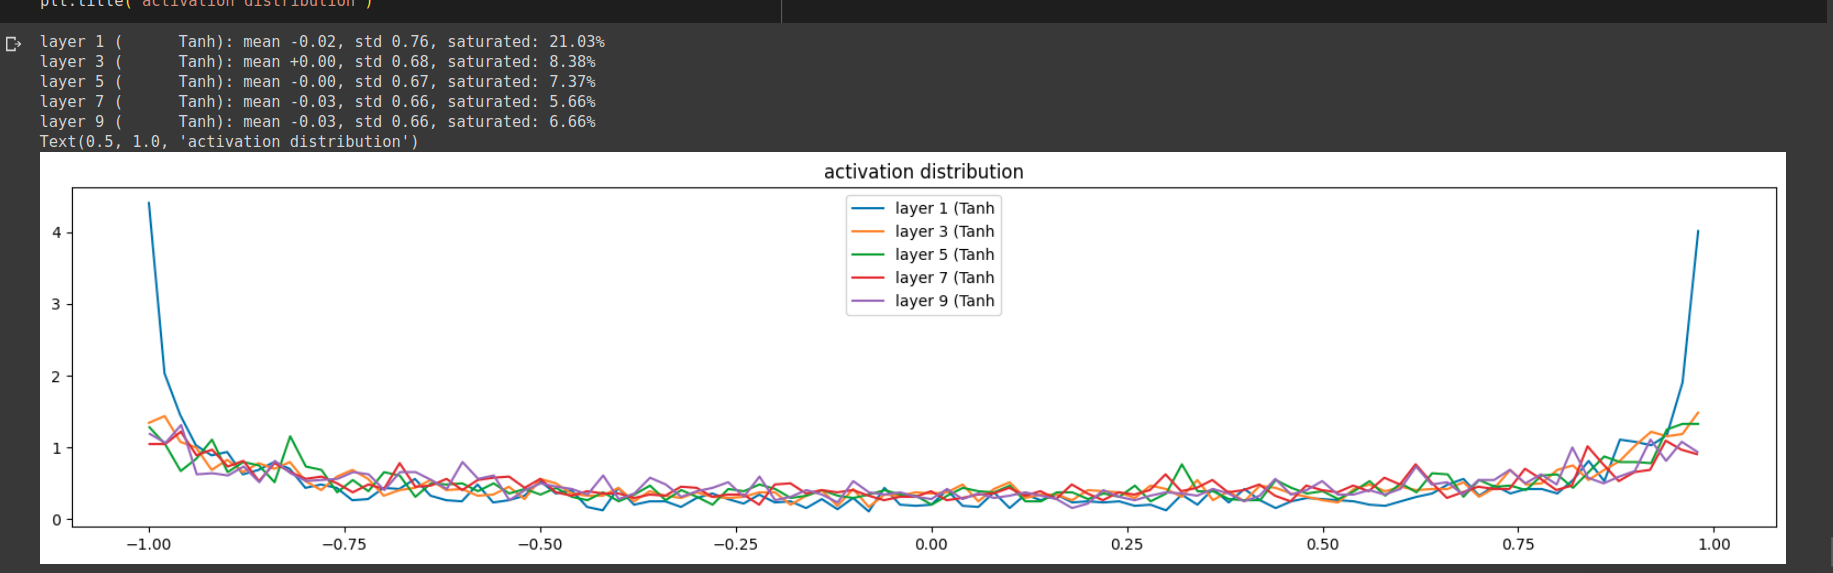

layer 1 (      Tanh): mean +0.000033, std 2.641852e-03
layer 3 (      Tanh): mean +0.000043, std 2.440831e-03
layer 5 (      Tanh): mean -0.000004, std 2.338152e-03
layer 7 (      Tanh): mean +0.000006, std 2.283551e-03
layer 9 (      Tanh): mean +0.000040, std 2.059027e-03


Text(0.5, 1.0, 'gradient distribution')

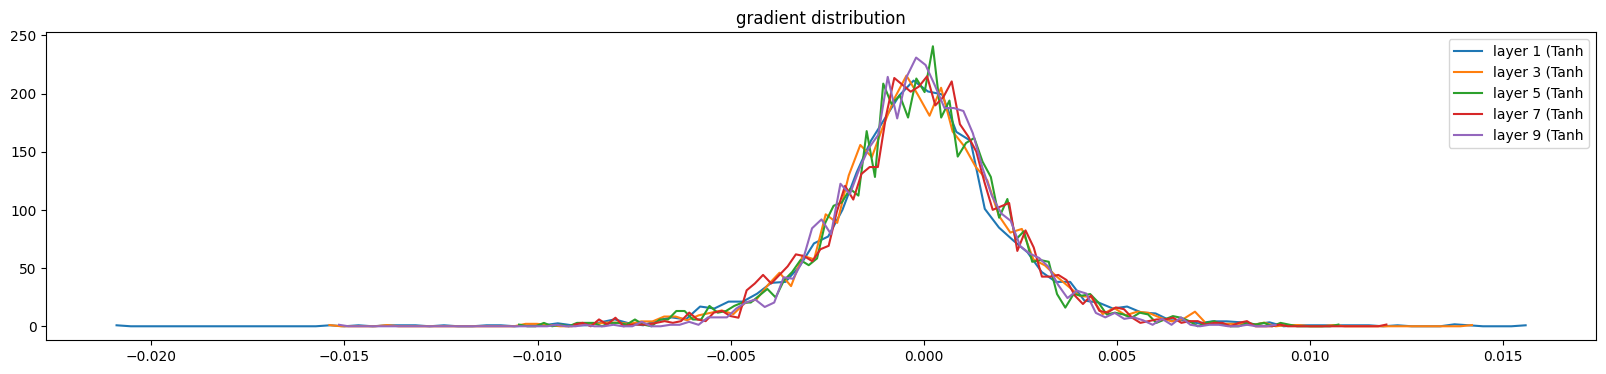

In [140]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

## Observations on the activations
- if the gain was way to small or not carefully initialized the gradient distribution between layer is behaving weirdly
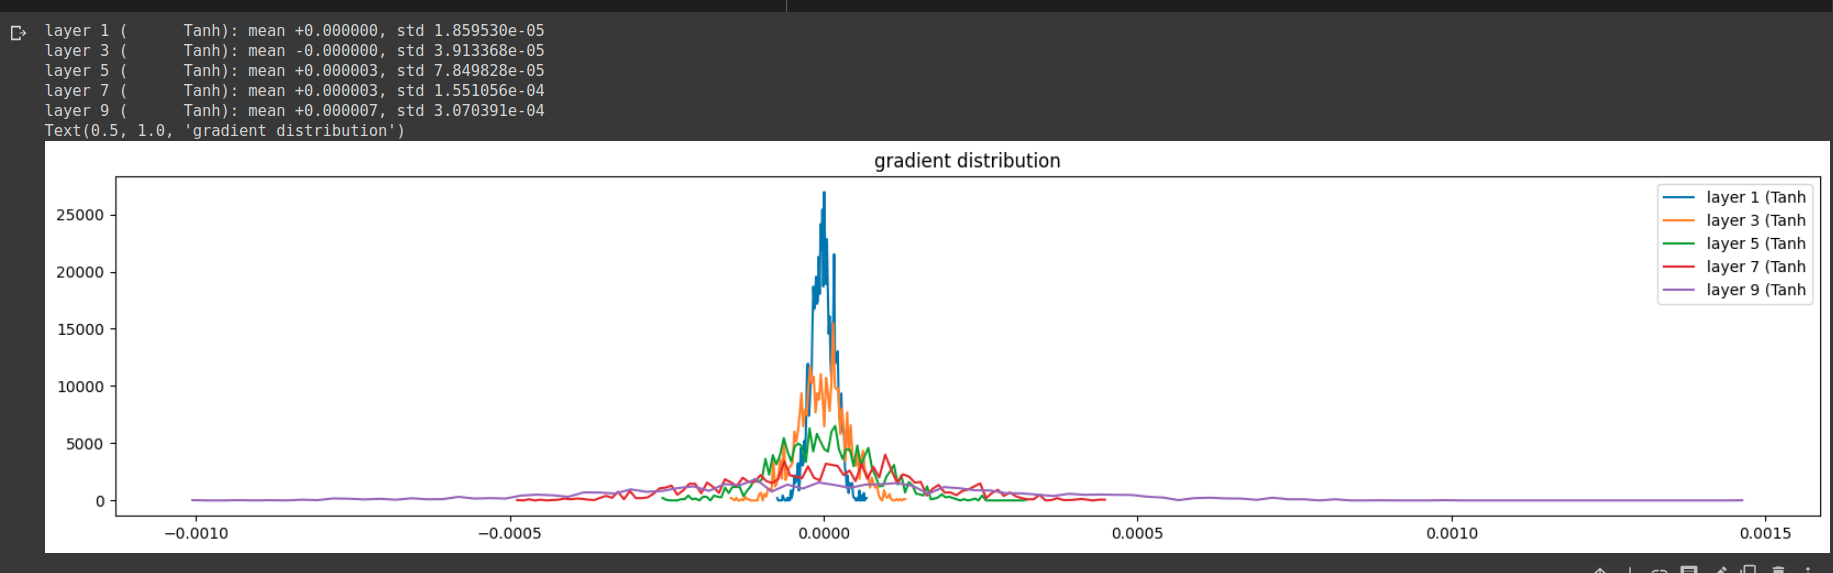

- if the gain 5/3 was there, it's being perfectly distributed
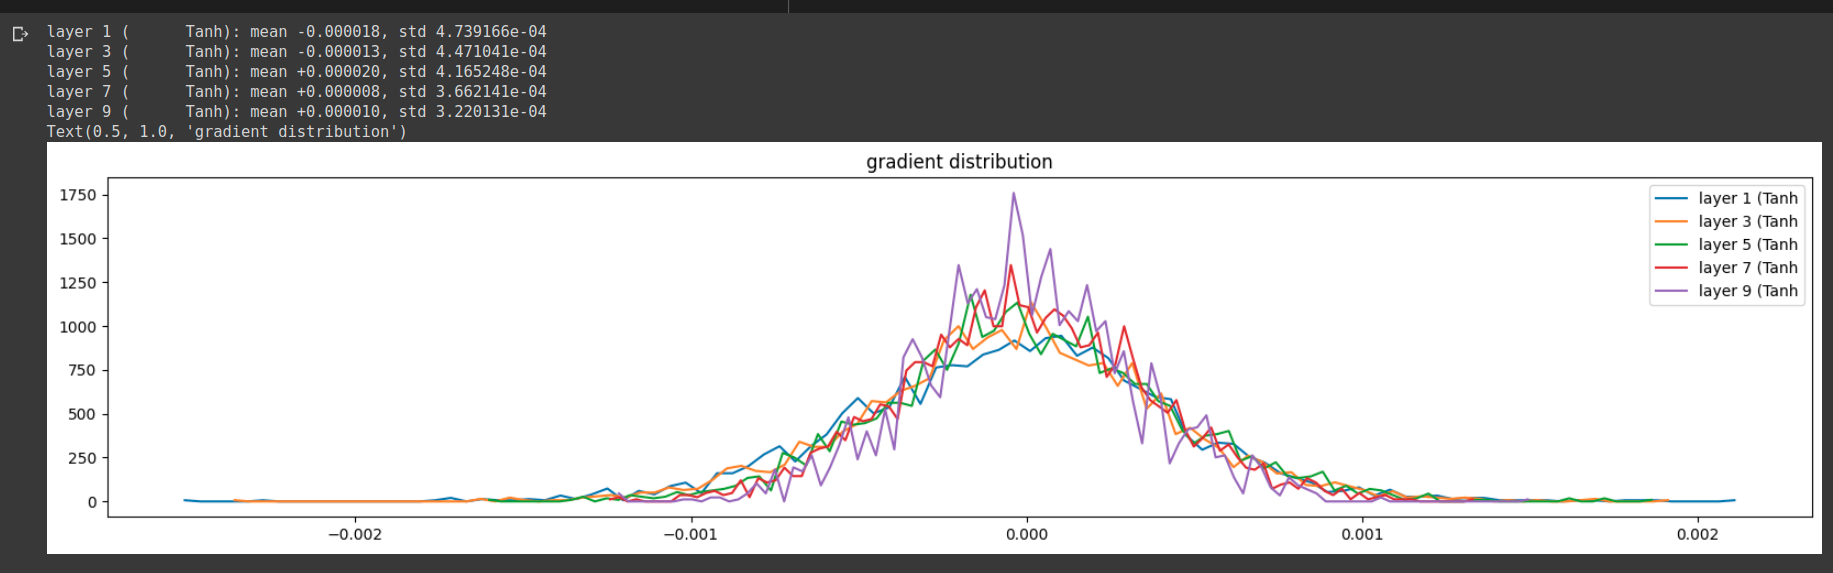

weight   (27, 10) | mean +0.000348 | std 8.758368e-03 | grad:data ratio 8.702222e-03
weight  (30, 100) | mean +0.000151 | std 1.007395e-02 | grad:data ratio 5.258169e-02
weight (100, 100) | mean -0.000087 | std 6.662836e-03 | grad:data ratio 6.450022e-02
weight (100, 100) | mean +0.000021 | std 5.148380e-03 | grad:data ratio 4.974074e-02
weight (100, 100) | mean +0.000015 | std 4.545035e-03 | grad:data ratio 4.419325e-02
weight (100, 100) | mean -0.000044 | std 3.829133e-03 | grad:data ratio 3.732290e-02
weight  (100, 27) | mean +0.000000 | std 1.436651e-02 | grad:data ratio 2.251752e-01


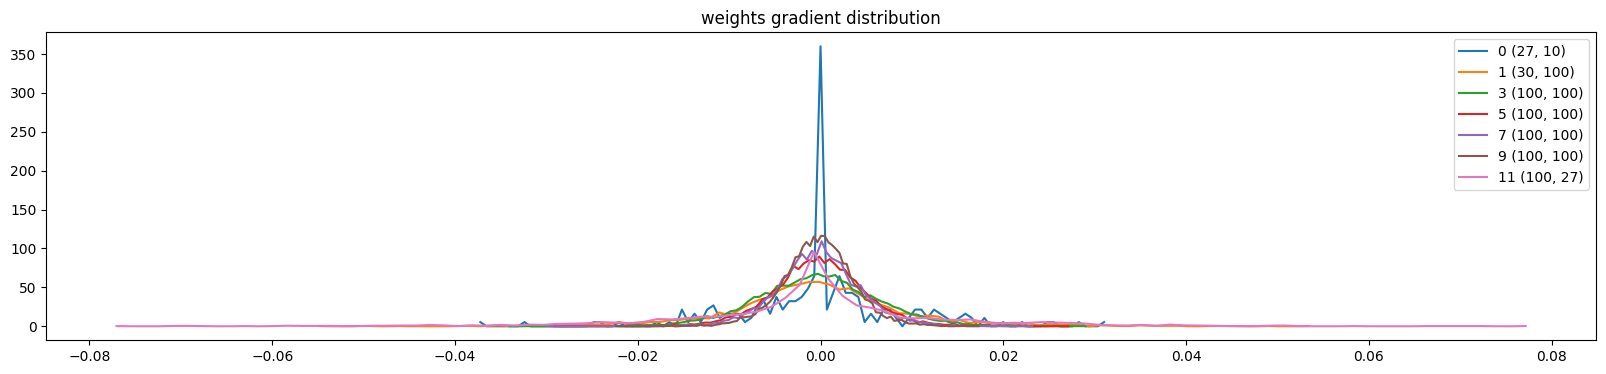

In [141]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

Text(0.5, 1.0, 'gradient distribution')

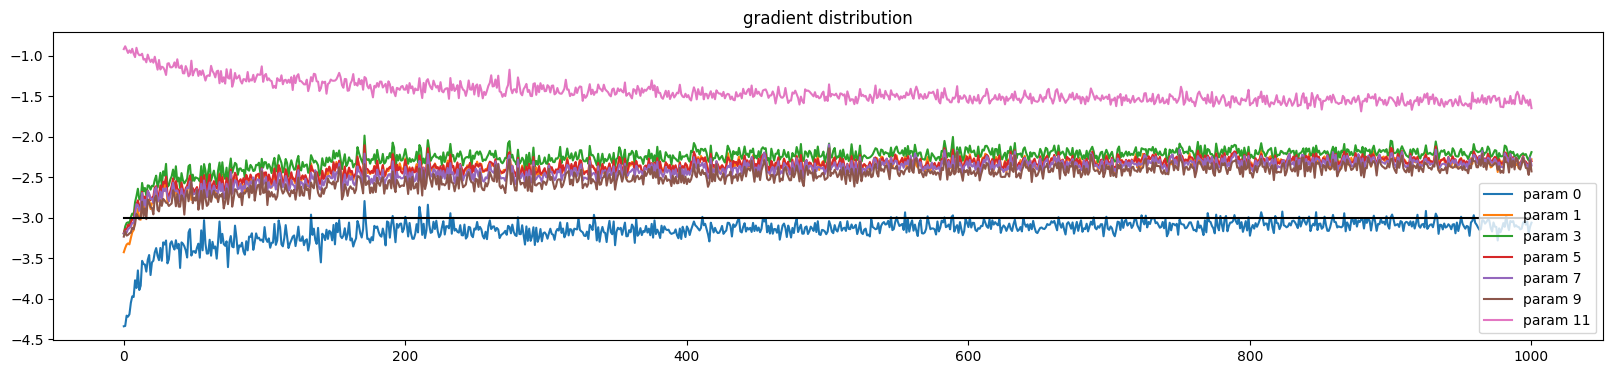

In [142]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('gradient distribution')

## Observation from gradient to data ratio and the data update to data ratio

- This ratio determines the learning velocity in each layer
- with respect to adjusting gain it has an impact on the data update during the backpropagation as well. this is due to the gradient to data ratio difference as the update = gradient * learning rate
- so it's important to set the learning rate as per the gain



## After batch normalization layer observation

- everything is pretty robust
- everything seem to be working perfectly fine even if we remove all the initialization mechanisms

- however update to data ratio has been changing based on the initialization as it depnds on data value of parameters. therefore it's important to re adjust the learning rates

In [143]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'dev': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('dev')

train 2.417053461074829
dev 2.4125304222106934


In [145]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mriaaimyan.
seelendheyah.
rethrstendrleg.
ade.
korelii.
shi.
jen.
edeisean.
aar.
ely.
korotelin.
shdrergshiries.
jinie.
jelilen.
puconu.
zarede.
jyrele.
ehs.
kar.
mystoyen.
